# Plot Something

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cmocean as cm

In [2]:
db = 'anu-tub.db'
session=cc.database.create_session(db)

In [3]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:40835 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


# Simulations

|Run Name | Parameters | Notes| 
|---|---|---|
| 'anu-tub-control-A'| REGRIDDING_COORDINATE_MODE = “ZSTAR” | Original case |
| 'anu-tub-adapt-A'| REGRIDDING_COORDINATE_MODE = "ADAPTIVE" | First attempt at adaptive with standard parameters | 
|'anu-tub-adapt-B'| REGRID_FILTER_SHALLOW_DEPTH = 100.0;  REGRID_FILTER_DEEP_DEPTH = 500.0 | No improvement on A | 
|'anu-tub-adapt-C'|REGRID_TIME_SCALE = 86400.0  | Much much worse | 
| - | REGRID_FILTER_SHALLOW_DEPTH = 0.0, REGRID_FILTER_DEEP_DEPTH = 0.0 | Velocity truncations - crashed on day 5. Output not saved |
|anu-tub-adapt-D|ADAPT_TIMESCALE = 8.64E+05|No better|
|anu-tub-adapt-E|ADAPT_MEAN_H = True|Nope.|
|anu-tub-adapt-F|ADAPT_SLOPE_CUTOFF = 0.05|very slightly worse than A|
|anu-tub-adapt-G|ADAPT_SLOPE_CUTOFF = 0.002|as above|
|anu-tub-adapt-H|ADAPT_RESTORING_TIMESCALE = 8.64E+04|Absolutely identical to A|
|anu-tub-adapt-I|ADAPT_RESTORING_TIMESCALE = 8.64E+06 | as above|
|anu-tub-adapt-J|ADAPT_TWIN_GRADIENT = False|Marginally worse than A|
|anu-tub-adapt-K|ADAPT_PHYSICAL_SLOPE = False | as above|
|anu-tub-adapt-L|ADAPT_RESTORE_MEAN = True |Absolutely identical to A|
|anu-tub-adapt-M|ADAPT_SMOOTH_MIN = 0.2|Marginally worse than A|
|anu-tub-adapt-N|ADAPT_ADJUSTMENT_SCALE = 0.5|HALVED THE ERROR!!|
|anu-tub-adapt-O|Reduce DT from 1080 to 180|Modest changes - certainly no better.|
|anu-tub-adapt-P|ADAPT_ADJUSTMENT_SCALE = 0.1| OK - I think we have identified the problem ...| 


**Conclusions:** It would seem that convective adjustment is misbehaving in regions where it shouldn't???

# Spinup Diagnostics


In [9]:
experiments=['anu-tub-control-A','anu-tub-adapt-A','anu-tub-adapt-O','anu-tub-adapt-P']

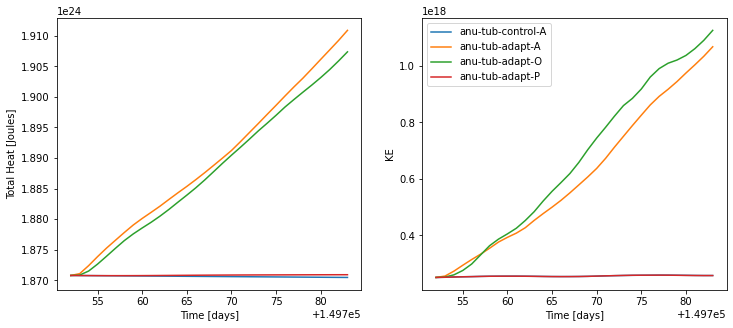

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

for experiment in experiments:
    variable = 'Heat'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']
    darray.plot(ax=ax[0],label=experiment)
    
    variable = 'KE'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']
    darray.sum('Layer').plot(ax=ax[1],label=experiment)
    
plt.legend()

# Plot N-S transect after a number of days.

Text(0.5, 0, 'Latitude')

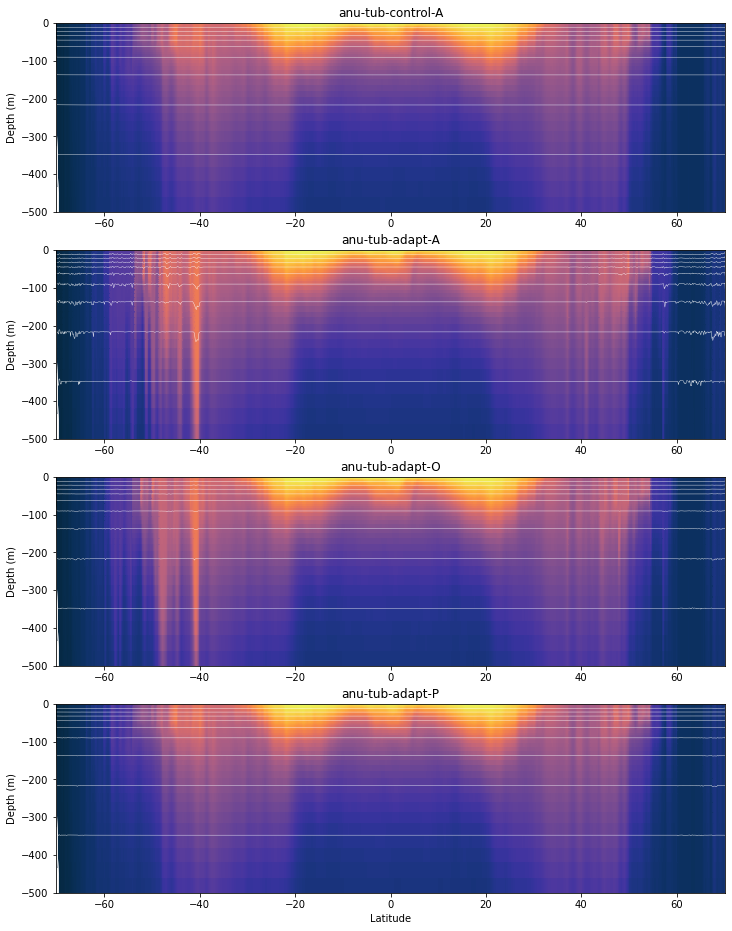

In [11]:
fig, ax = plt.subplots(4,1,figsize=(12,16))
vlev = np.linspace(-2,32,34)

i=0
timeslice = -1
for experiment in experiments:
    harray = cc.querying.getvar(experiment, 'h', session,ncfile='prog.nc')
    tarray = cc.querying.getvar(experiment, 'temp', session,ncfile='prog.nc')
    


    h1 = harray.isel(Time=timeslice).isel(xh=30).cumsum('zl')
    for p in range(15):
        ax[i].plot(h1.yh,-h1.isel(zl=p*5),color='w',linewidth=0.4)
    
    t1 = tarray.isel(Time=timeslice).isel(xh=30)
    ax[i].pcolormesh(t1.yh,-h1,t1,cmap=cm.cm.thermal)
    ax[i].set_ylim([-500,0])
    ax[i].set_ylabel('Depth (m)')
    ax[i].set_title(experiment)
    i+=1

ax[i-1].set_xlabel('Latitude')
